### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from tqdm.auto import tqdm

### Gaussians located at +/- mu

In [8]:
def get_log_err(
    mu: np.ndarray,
    sigma: np.ndarray,
    n_train: int,
    use_perfect_mu: bool = False,
    use_perfect_sigma: bool = False,
    use_identity_sigma: bool = False
) -> float:
    """
    mu and sigma are both diagonal

    Returns the log_10 error of the estimator obtained from n_train samples.
    """
    assert mu.shape == sigma.shape
    (d,) = mu.shape

    xs_train = np.random.normal(mu, np.sqrt(sigma), size=(n_train, d))

    mu_hat = mu if use_perfect_mu else np.mean(xs_train, axis=0)
    sigma_hat = (
        np.diag(sigma)
        if use_perfect_sigma
        else np.cov(
            xs_train,
            rowvar=False,
        )
    ) if not use_identity_sigma else np.eye(d)

    if sigma_hat.ndim == 0:
        return 0.5
    w_hat = np.linalg.pinv(sigma_hat) @ mu_hat

    mu_proj = w_hat @ mu
    sigma_proj = w_hat @ (sigma * w_hat)

    # Compute probability N(mu_proj, sigma_proj) <= 0
    norm_var = scipy.stats.norm(loc=mu_proj, scale=np.sqrt(sigma_proj))
    return norm_var.logcdf(0) / np.log(10)


seed = 1
np.random.seed(seed)
print(get_log_err(np.arange(5), np.arange(5) + 1, n_train=40, use_identity_sigma=True))
np.random.seed(seed)
print(get_log_err(np.arange(5), np.arange(5) + 1, n_train=40))
np.random.seed(seed)
print(get_log_err(np.arange(5), np.arange(5) + 1, n_train=40, use_perfect_sigma=True))
print(
    get_log_err(
        np.arange(5),
        np.arange(5) + 1,
        n_train=1,
        use_perfect_mu=True,
        use_perfect_sigma=True,
    )
)


-2.38164170362202
-2.162418690708755
-2.4346962836123933
-2.4584377824807317


In [9]:
SEED = 2
np.random.seed(SEED)

D = 100
SIGMA = np.random.uniform(size=D)  # WLOG we can make sigma diagonal
MU = np.random.uniform(size=D) / np.sqrt(D) * 2


n_trains = np.logspace(0.1, 5, 120, dtype=int)
err_opt = get_log_err(MU, SIGMA, n_train=1, use_perfect_mu=True, use_perfect_sigma=True)
errs = []
errs_p = []
errs_eye = []
for n in tqdm(n_trains):
    np.random.seed(SEED)
    errs.append(get_log_err(MU, SIGMA, n))
    np.random.seed(SEED)
    errs_p.append(get_log_err(MU, SIGMA, n, use_perfect_sigma=True))
    np.random.seed(SEED)
    errs_eye.append(get_log_err(MU, SIGMA, n, use_identity_sigma=True))

errs = np.array(errs)
errs_p = np.array(errs_p)
errs_eye = np.array(errs_eye)

  0%|          | 0/120 [00:00<?, ?it/s]

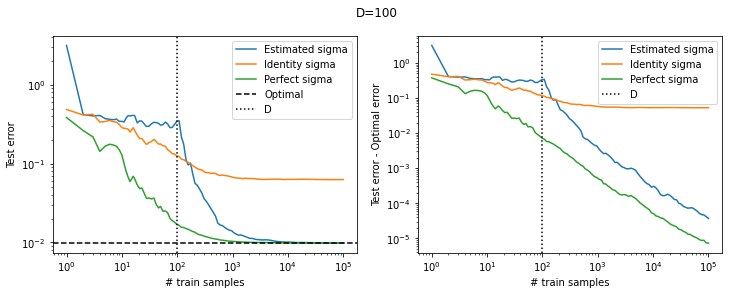

In [10]:
plt.figure(figsize=(12, 4))
plt.suptitle(f"D={D}")

plt.subplot(1, 2, 1)
plt.plot(n_trains, 10 ** errs, label="Estimated sigma")
plt.plot(n_trains, 10 ** errs_eye, label="Identity sigma")
plt.plot(n_trains, 10 ** errs_p, label="Perfect sigma")
plt.axhline(10 ** err_opt, label="Optimal", color="black", linestyle="--")
plt.axvline(D, label="D", color="black", linestyle=":")

plt.xlabel("# train samples")
plt.ylabel("Test error")
plt.xscale("log")
plt.yscale("log")
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(n_trains, 10 ** errs - 10 ** err_opt, label="Estimated sigma")
plt.plot(n_trains, 10 ** errs_eye - 10 ** err_opt, label="Identity sigma")
plt.plot(n_trains, 10 ** errs_p - 10 ** err_opt, label="Perfect sigma")
plt.axvline(D, label="D", color="black", linestyle=":")

plt.ylabel("Test error - Optimal error")
plt.xlabel("# train samples")
plt.xscale("log")
plt.yscale("log")
plt.legend();

In the above plot, we see that with a perfect sigma, we start off with pretty good performance. In order to get a cliff with a perfect sigma, we need to start off with bad performance...